#

In [61]:
import numpy as np
from tqdm import tqdm
import cv2
import pandas as pd
import os
from IPython.display import display
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# config global variables

In [62]:
debugMode = True
testWorkflow = True
numberData = 25000
numberTest = 12500
batchSize = 32
epochs = 20

if testWorkflow:
    numberData = 1000
    numberTest = 50
    batchSize = 4
    epochs = 1

# ResNet50
## read data for ResNet50

In [63]:
inputSizeResNet = 224
   
x_ResNet = np.zeros((numberData, inputSizeResNet, inputSizeResNet, 3), dtype=np.uint8)
y_ResNet = np.zeros((numberData, 1), dtype=np.uint8)

for index in tqdm(range(0, numberData, 2)):
    x_ResNet[index] = cv2.resize(cv2.imread('train/cat.%d.jpg' %(index/2))[:,:,::-1], (inputSizeResNet, inputSizeResNet))
    x_ResNet[index + 1] = cv2.resize(cv2.imread('train/dog.%d.jpg' %(index/2))[:,:,::-1], (inputSizeResNet, inputSizeResNet))
    y_ResNet[index + 1] = 1

100%|██████████| 500/500 [00:05<00:00, 93.68it/s]


## split as train and val

In [64]:
from sklearn.model_selection import train_test_split

x_train_ResNet, x_val_ResNet, y_train_ResNet, y_val_ResNet = train_test_split(x_ResNet, y_ResNet, test_size=0.2, random_state=8)

if testWorkflow:
    print (x_train_ResNet[:, 0, 0, 0].size)
    print (y_val_ResNet.size)

800
200


## build the transfer learning mode

In [65]:
import keras
from keras.layers import GlobalAveragePooling2D, Dense, Input, Dropout
from keras.models import Model
from keras.applications.resnet50 import ResNet50

base_model_ResNet = ResNet50(input_tensor=Input((inputSizeResNet, inputSizeResNet, 3)), weights='imagenet', include_top=False)

for layers in base_model_ResNet.layers:
    layers.trainable = False

x_ResNet = GlobalAveragePooling2D()(base_model_ResNet.output)
x_ResNet = Dropout(0.25)(x_ResNet)
prediction_ResNet = Dense(1, activation='sigmoid')(x_ResNet)
model_ResNet = Model(base_model_ResNet.input, prediction_ResNet)

if testWorkflow:
    print('done')

done


## fit ResNet

In [70]:
model_ResNet.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model_ResNet.fit(x_train_ResNet, y_train_ResNet, batch_size=batchSize, epochs=epochs, validation_data=(x_val_ResNet, y_val_ResNet), verbose=debugMode)

if testWorkflow:
    print ('done')

Train on 800 samples, validate on 200 samples
Epoch 1/5
800/800 [==============================] - 189s 237ms/step - loss: 0.2595 - acc: 0.8962 - val_loss: 0.1347 - val_acc: 0.9500
Epoch 2/5
800/800 [==============================] - 182s 227ms/step - loss: 0.1966 - acc: 0.9137 - val_loss: 0.0728 - val_acc: 0.9700
Epoch 3/5
800/800 [==============================] - 184s 230ms/step - loss: 0.1643 - acc: 0.9275 - val_loss: 0.0904 - val_acc: 0.9650
Epoch 4/5
800/800 [==============================] - 191s 239ms/step - loss: 0.1784 - acc: 0.9238 - val_loss: 0.1088 - val_acc: 0.9600
Epoch 5/5
800/800 [==============================] - 194s 243ms/step - loss: 0.2043 - acc: 0.9187 - val_loss: 0.1496 - val_acc: 0.9450
done


## display history

In [68]:
print (history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


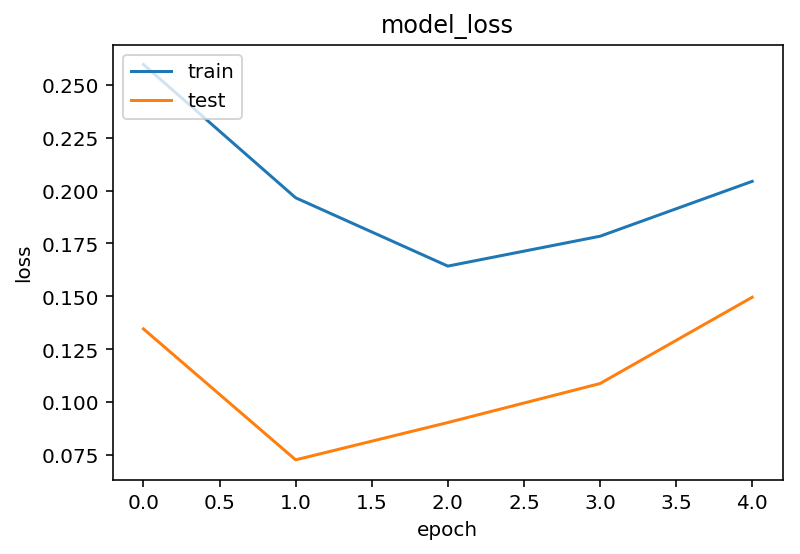

In [71]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## display SVG

In [66]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(model_ResNet).create(prog='dot', format='svg'))

## display layer name and index

In [29]:
layers = zip([x.name for x in model_ResNet.layers], range(len(model_ResNet.layers)))

display(list(layers))


[('input_1', 0),
 ('conv1_pad', 1),
 ('conv1', 2),
 ('bn_conv1', 3),
 ('activation_1', 4),
 ('max_pooling2d_1', 5),
 ('res2a_branch2a', 6),
 ('bn2a_branch2a', 7),
 ('activation_2', 8),
 ('res2a_branch2b', 9),
 ('bn2a_branch2b', 10),
 ('activation_3', 11),
 ('res2a_branch2c', 12),
 ('res2a_branch1', 13),
 ('bn2a_branch2c', 14),
 ('bn2a_branch1', 15),
 ('add_1', 16),
 ('activation_4', 17),
 ('res2b_branch2a', 18),
 ('bn2b_branch2a', 19),
 ('activation_5', 20),
 ('res2b_branch2b', 21),
 ('bn2b_branch2b', 22),
 ('activation_6', 23),
 ('res2b_branch2c', 24),
 ('bn2b_branch2c', 25),
 ('add_2', 26),
 ('activation_7', 27),
 ('res2c_branch2a', 28),
 ('bn2c_branch2a', 29),
 ('activation_8', 30),
 ('res2c_branch2b', 31),
 ('bn2c_branch2b', 32),
 ('activation_9', 33),
 ('res2c_branch2c', 34),
 ('bn2c_branch2c', 35),
 ('add_3', 36),
 ('activation_10', 37),
 ('res3a_branch2a', 38),
 ('bn3a_branch2a', 39),
 ('activation_11', 40),
 ('res3a_branch2b', 41),
 ('bn3a_branch2b', 42),
 ('activation_12', 43)

## CAM

In [ ]:

np.random.seed(666)

weights = model_ResNet.layers[-1].get_weights()[0]        
modelCAM = Model(model_ResNet.input, [model_ResNet.get_layer('add_80').output, model_ResNet.output])

figCAM = plt.figure(figsize=(12, 14))
for i in range(4):
    ax = figCAM.add_subplot(1, 4, i+1)

    sourceImg = cv2.imread('test/%d.jpg' % np.random.randint(0, 12499))[:, :, ::-1]
    sourceImg = cv2.resize(sourceImg, (inputSize, inputSize))
    testImg = sourceImg.copy()
    testImg.astype(np.float32)
    testImg = np.expand_dims(testImg, axis=0)

    out_modelResNetBase, prediction = modelCAM.predict(testImg)
    out_modelResNetBase = out_modelResNetBase[0]
    prediction = prediction[0]

    if prediction < 0.5:
        ax.set_title('cat with prob: %.2f%%' % ((1 - prediction) * 100))
    else:
        ax.set_title('dog with prob: %.2f%%' % (prediction * 100))

    cam = (prediction - 0.5) * np.matmul(out_modelResNetBase, weights)
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    cam = cv2.resize(cam, (inputSizeResNet, inputSizeResNet))
    cam *= 255
    cam = cam.astype(np.uint8)

    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    heatmap[np.where(cam <= 100)] = 0

    out = cv2.addWeighted(sourceImg, 0.8, heatmap, beta=0.4, gamma=0)
    out = cv2.resize(out, dsize=(500, 500))

    ax.imshow(out)
    
plt.show()


# fine tuning

In [ ]:
# #unlock all pre-trained layers
# for layers in base_model_ResNet.layers:
#     layers.trainable = True

# model.compile(optimizer='Adam',
#           loss='binary_crossentropy',
#           metrics=['accuracy'])
# model.fit(x_train, y_train, batch_size=2, epochs=1, validation_data=(x_val, y_val))

In [10]:
def writeSubmission(pred, predNumber, subIndex):
    submission = pd.read_csv("sample_submission.csv")

    for index in tqdm(range(predNumber)):
        submission.at[index, "label"] = pred[index]

    submission.to_csv('submission%d.csv' %subIndex, index=None)

## predict

In [11]:

xTestResNet = np.zeros((numberTest, inputSizeResNet, inputSizeResNet, 3), dtype=np.uint8)

for index in tqdm(range(numberTest)):
    xTestResNet[index] = cv2.resize(cv2.imread('test/%d.jpg' %(index+1))[:,:,::-1], (inputSizeResNet, inputSizeResNet))
    
yPredResNet = model_ResNet.predict(xTestResNet, verbose=debugMode)
yPredResNet = yPredResNet.clip(min=0.005, max=0.995)

writeSubmission(yPredResNet, numberTest, 1)

# submission.head(50)

# print (testFilenames[0])
# print (testFilenames[0])
# def jwkj_get_filePath_fileName_fileExt(filename):  
#     (filepath,tempfilename) = os.path.split(filename);  
#     (shotname,extension) = os.path.splitext(tempfilename);  
#     return filepath,shotname,extension  

# filepath,shotname,extension = jwkj_get_filePath_fileName_fileExt(testFilenames[0])
# print (filepath)
# print (shotname)
# print (extension)
# for filename in testFilenames:
#     index = filename

100%|██████████| 50/50 [00:00<00:00, 231.32it/s]


50/50 [==============================] - 9s 178ms/step


100%|██████████| 50/50 [00:00<00:00, 29446.11it/s]


In [ ]:
# temp = pd.read_csv("submission1.csv")
# temp.head(52)

# InceptionV3

In [12]:
inputSizeInception = 299

from keras.layers import Lambda
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as piInception
 
x_inception = np.zeros((numberData, inputSizeInception, inputSizeInception, 3), dtype=np.uint8)
y_inception = np.zeros((numberData, 1), dtype=np.uint8)

for index in tqdm(range(0, numberData, 2)):
    x_inception[index] = cv2.resize(cv2.imread('train/cat.%d.jpg' %(index/2))[:,:,::-1], (inputSizeInception, inputSizeInception))
    x_inception[index + 1] = cv2.resize(cv2.imread('train/dog.%d.jpg' %(index/2))[:,:,::-1], (inputSizeInception, inputSizeInception))
    y_inception[index + 1] = 1

if testWorkflow:
    print ("done")


100%|██████████| 500/500 [00:04<00:00, 110.61it/s]

done


In [13]:
x_train_inception, x_val_inception, y_train_inception, y_val_inception = train_test_split(x_inception, y_inception, test_size=0.2, random_state=10)

input_base_inceptionV3 = Input((inputSizeInception, inputSizeInception, 3))
input_base_inceptionV3 = Lambda(piInception)(input_base_inceptionV3)
base_model_InceptionV3 = InceptionV3(input_tensor=input_base_inceptionV3, weights='imagenet', include_top=False)

for layers in base_model_InceptionV3.layers:
    layers.trainable = False

x = GlobalAveragePooling2D()(base_model_InceptionV3.output)
x = Dropout(0.25)(x)
prediction_InceptionV3 = Dense(1, activation='sigmoid')(x)
model_InceptionV3 = Model(base_model_InceptionV3.input, prediction_InceptionV3)
   
model_InceptionV3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_InceptionV3.fit(x_train_inception, y_train_inception, batch_size=batchSize, epochs=epochs, validation_data=(x_val_inception, y_val_inception), verbose=debugMode)

if testWorkflow:
    print ('done')

Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 212s 265ms/step - loss: 0.4523 - acc: 0.7925 - val_loss: 0.1899 - val_acc: 0.9200
done


In [15]:
xTestInception = np.zeros((numberTest, inputSizeInception, inputSizeInception, 3), dtype=np.float32)

for index in tqdm(range(numberTest)):
    xTestInception[index] = cv2.resize(cv2.imread('test/%d.jpg' %(index+1))[:,:,::-1], (inputSizeInception, inputSizeInception))

# xTestInception = piInception(xTestInception)

100%|██████████| 50/50 [00:00<00:00, 195.01it/s]


In [16]:
yPredInceptionV3 = model_InceptionV3.predict(xTestInception, verbose=debugMode)
yPredInceptionV3 = yPredInceptionV3.clip(min=0.005, max=0.995)

writeSubmission(yPredInceptionV3, numberTest, 2)

50/50 [==============================] - 12s 245ms/step


100%|██████████| 50/50 [00:00<00:00, 24727.65it/s]


# InceptionResNetV2

In [20]:

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input as piInceptionResNetV2

input_base_InceptionResNetV2 = Input((inputSizeInception, inputSizeInception, 3))
input_base_InceptionResNetV2 = Lambda(piInceptionResNetV2)(input_base_InceptionResNetV2)
base_model_InceptionResNetV2 = InceptionResNetV2(input_tensor=input_base_InceptionResNetV2, weights='imagenet', include_top=False)

for layers in base_model_InceptionResNetV2.layers:
    layers.trainable = False

x = GlobalAveragePooling2D()(base_model_InceptionResNetV2.output)
x = Dropout(0.25)(x)
prediction_InceptionResNetV2 = Dense(1, activation='sigmoid')(x)
model_InceptionResNetV2 = Model(base_model_InceptionResNetV2.input, prediction_InceptionResNetV2)

if testWorkflow:
    print('done')
    
model_InceptionResNetV2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_InceptionResNetV2.fit(x_train_inception, y_train_inception, batch_size=batchSize, epochs=epochs, validation_data=(x_val_inception, y_val_inception), verbose=debugMode)

if testWorkflow:
    print ('done')

done
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 425s 531ms/step - loss: 0.4220 - acc: 0.8113 - val_loss: 0.1058 - val_acc: 0.9900
done


In [21]:
yPredInceptionResNetV2 = model_InceptionResNetV2.predict(xTestInception, verbose=debugMode)
yPredInceptionResNetV2 = yPredInceptionResNetV2.clip(min=0.005, max=0.995)

writeSubmission(yPredInceptionResNetV2, numberTest, 3)

50/50 [==============================] - 26s 521ms/step


100%|██████████| 50/50 [00:00<00:00, 12912.70it/s]


# pick two closest scores for each test record then average them

In [60]:
submission1 = pd.read_csv('submission1.csv')
submission2 = pd.read_csv('submission2.csv')
submission3 = pd.read_csv('submission3.csv')
submission  = pd.read_csv('sample_submission.csv')

for element in list(zip(range(numberTest),submission1['label'], submission2['label'], submission3['label'])):
    labels = element[1:]
    submission.at[element[0], "label"] = max(labels) if min(labels) > 0.5 else (min(labels) if max(labels) < 0.5 else np.mean(labels))
    print(submission.at[element[0], "label"], labels)

0.9606589078903198 (0.8641621470451355, 0.8129083514213562, 0.9606589078903198)
0.9948016405105592 (0.9948016405105592, 0.8346207737922668, 0.8930301070213318)
0.9950000047683716 (0.9950000047683716, 0.8608768582344055, 0.9326859116554259)
0.9498804807662964 (0.9430806636810304, 0.8568711876869202, 0.9498804807662964)
0.004999999888241291 (0.004999999888241291, 0.010508649051189423, 0.008539602160453795)
0.004999999888241291 (0.004999999888241291, 0.023610729724168774, 0.12645091116428375)
0.004999999888241291 (0.004999999888241291, 0.062232468277215965, 0.024689506739377972)
0.004999999888241291 (0.004999999888241291, 0.025416074320673943, 0.08774805814027786)
0.005610832013189793 (0.005610832013189793, 0.010411252267658709, 0.02935463935136795)
0.008329194039106369 (0.008329194039106369, 0.024052662774920464, 0.0107254134491086)
0.007819920778274536 (0.007819920778274536, 0.020667959004640583, 0.02664477750658989)
0.8224149942398071 (0.7772306203842163, 0.6234591603279114, 0.82241499